# Long Short-Term Memory (LSTM)

Las redes LSTM son muy eficientes para datos secuenciales, donde el orden importa. Piensa en texto (una secuencia de palabras), series temporales (precios de acciones a lo largo del tiempo o temperatura) o audio.

Tienen un "estado interno" o "memoria" que se actualiza en cada paso de la secuencia. Esto les permite recordar información de pasos anteriores para tomar decisiones en el presente. 

Ejemplos: Predecir la siguiente palabra en una oración, clasificar el sentimiento de una reseña de película, o predecir el clima de mañana basándose en los datos de la última semana.

### Dataset
Crearemos uno: una simple onda senoidal. Esto es ideal porque es un patrón periódico y predecible, lo que nos permite verificar visualmente si nuestro modelo está aprendiendo correctamente.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import LeaveOneGroupOut
from tensorflow.keras import Input
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
# ===== CONFIGURACIÓN DE REPRODUCIBILIDAD =====
import random
import numpy as np
import tensorflow as tf
import os

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# SEMILLA PRINCIPAL DEL PROYECTO
PROJECT_SEED = 42
set_seeds(PROJECT_SEED)

print(f"🔒 Reproducibilidad garantizada con seed: {PROJECT_SEED}")

🔒 Reproducibilidad garantizada con seed: 42


In [3]:
def create_subject_sequences(X, y, subjects, window_size=10, stride=1):
    """
    Genera secuencias tipo sliding window de largo window_size
    para cada sujeto por separado.

    Parámetros:
        X: np.ndarray de forma (N, F) con todas las muestras
        y: np.ndarray de forma (N,) con etiquetas bin. por muestra
        subjects: np.ndarray de forma (N,) con id de sujeto por muestra
        window_size: int, número de filas por secuencia
        stride: int, paso entre ventanas deslizantes

    Devuelve:
        X_seq: np.ndarray (M, window_size, F)
        y_seq: np.ndarray (M,)          -- etiqueta de la última muestra de cada ventana
        subj_seq: np.ndarray (M,)       -- id de sujeto de cada secuencia
    """
    X_seqs, y_seqs, subj_seqs = [], [], []
    for subj in np.unique(subjects):
        mask = (subjects == subj)
        X_subj = X[mask]
        y_subj = y[mask]

        # ⚠️ Normalización z-score por sujeto
        mean = np.mean(X_subj, axis=0)
        std = np.std(X_subj, axis=0)
        std[std == 0] = 1  # Evitar división por cero
        X_subj = (X_subj - mean) / std

        L = len(X_subj)
        if L < window_size:
            continue

        # ventanas con stride configurable
        for start in range(0, L - window_size + 1, stride):
            end = start + window_size
            X_seqs.append(X_subj[start:end])
            y_seqs.append(y_subj[end - 1])
            subj_seqs.append(subj)

    return np.array(X_seqs), np.array(y_seqs), np.array(subj_seqs)


In [4]:
df = pd.read_csv(r'features_30_075\features.csv', index_col=0)

In [5]:
for i in range(1, len(df['label'].unique())+1):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 1 total: 73554
Label: 2 total: 48333
Label: 3 total: 42875
Label: 4 total: 43068
Label: 5 total: 13228


In [6]:
# Filtrar los que sean 2
df = df[df['label'] != 2]

# Reasignar las clases
df['label'] = df['label'].apply(lambda x: 0 if x in [1, 5] else 1)

In [7]:
for i in range(0, len(df['label'].unique())):
    mask = (df['label'] == i).sum()
    print(f'Label: {i} total: {mask}')

Label: 0 total: 86782
Label: 1 total: 85943


In [8]:
feature_cols = [col for col in df.columns if col not in ['label', 'subject']]

In [9]:
X = df[feature_cols].values
y = df['label'].values
subjects = df['subject'].values

import numpy as np
import pandas as pd

df_temp = pd.DataFrame({
    'subject': np.ravel(subjects),
    'label': np.ravel(y)
})

# Contar clases únicas por sujeto
clases_por_sujeto = df_temp.groupby('subject')['label'].nunique()

# Filtrar sujetos que tienen ambas clases (0 y 1)
sujetos_validos = clases_por_sujeto[clases_por_sujeto == 2].index.tolist()

# Obtener índices válidos
indices_validos = df_temp['subject'].isin(sujetos_validos)

# Filtrar X, y, subjects
X_filtrado = X[indices_validos]
y_filtrado = y[indices_validos]
subjects_filtrados = subjects[indices_validos]

from sklearn.preprocessing import RobustScaler

# Suponiendo que ya tienes X, y, subjects
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_filtrado)

print(X_scaled.shape)  # (num_samples, seq_len, num_features)
print(y_filtrado.shape)

(137712, 52)
(137712,)


In [10]:
X_seq, y_seq, subj_seq = create_subject_sequences(X_scaled, y_filtrado, subjects_filtrados, window_size=10, stride=5)

In [11]:
print(X_seq.shape)

(27506, 10, 52)


In [12]:
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

GPUs disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


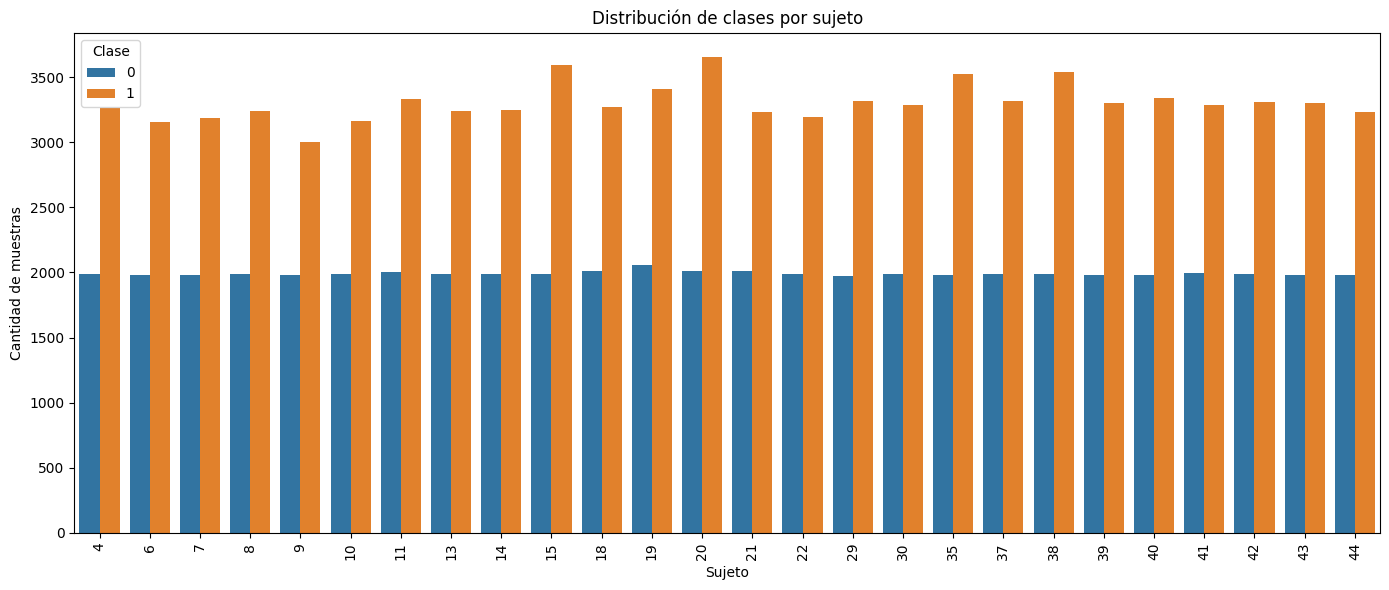

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurar que son arrays 1D
subjects_flat = np.ravel(subjects_filtrados)
y_flat = np.ravel(y_filtrado)

# Crear DataFrame temporal para análisis
df_temp = pd.DataFrame({
    'subject': subjects_flat,
    'label': y_flat
})

# Contar clases por sujeto
counts = df_temp.groupby(['subject', 'label']).size().reset_index(name='count')

# Gráfico de barras
plt.figure(figsize=(14, 6))
sns.barplot(data=counts, x='subject', y='count', hue='label')
plt.title('Distribución de clases por sujeto')
plt.xlabel('Sujeto')
plt.ylabel('Cantidad de muestras')
plt.xticks(rotation=90)
plt.legend(title='Clase')
plt.tight_layout()
plt.show()


🧪 Validando grupo 1 de 37
Clases en test (sujeto 1): {0: 396, 1: 652}
Epoch 1/50
414/414 [==============================] - 5s 3ms/step - loss: 0.6792 - accuracy: 0.5455 - val_loss: 0.6280 - val_accuracy: 0.7166

Epoch 00001: val_accuracy improved from -inf to 0.71660, saving model to modelos\mejor_modelo_1.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5929 - accuracy: 0.7289 - val_loss: 0.5492 - val_accuracy: 0.8597

Epoch 00002: val_accuracy improved from 0.71660 to 0.85973, saving model to modelos\mejor_modelo_1.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5158 - accuracy: 0.8153 - val_loss: 0.4799 - val_accuracy: 0.8874

Epoch 00003: val_accuracy improved from 0.85973 to 0.88740, saving model to modelos\mejor_modelo_1.h5
Epoch 4/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4471 - accuracy: 0.8535 - val_loss: 0.4227 - val_accuracy: 0.9055

Epoch 00004: val_accuracy improved from 0.88740 to 0.9

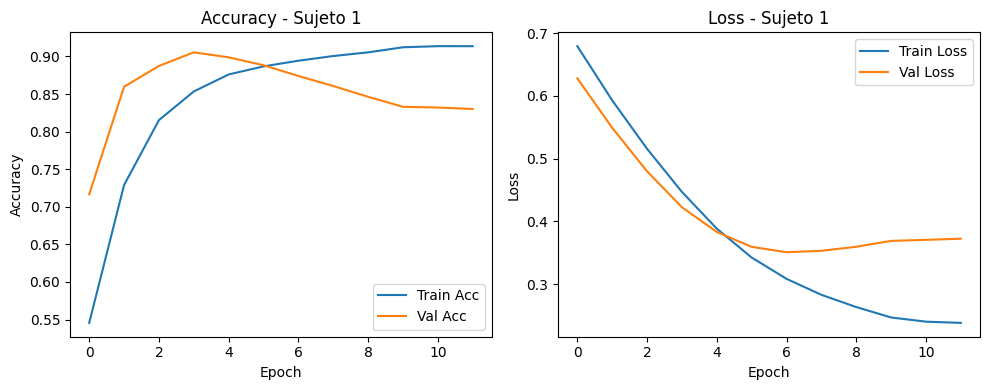

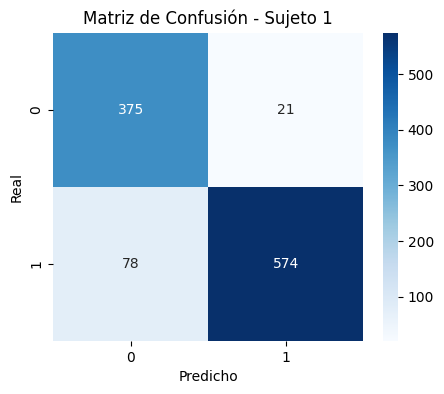

📄 Reporte de clasificación - Sujeto 1
              precision    recall  f1-score   support

           0     0.8278    0.9470    0.8834       396
           1     0.9647    0.8804    0.9206       652

    accuracy                         0.9055      1048
   macro avg     0.8963    0.9137    0.9020      1048
weighted avg     0.9130    0.9055    0.9065      1048


🧪 Validando grupo 2 de 37
Clases en test (sujeto 2): {0: 395, 1: 631}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6501 - accuracy: 0.5398 - val_loss: 0.6049 - val_accuracy: 0.6784

Epoch 00001: val_accuracy improved from -inf to 0.67836, saving model to modelos\mejor_modelo_2.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5451 - accuracy: 0.7315 - val_loss: 0.5023 - val_accuracy: 0.8635

Epoch 00002: val_accuracy improved from 0.67836 to 0.86355, saving model to modelos\mejor_modelo_2.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4

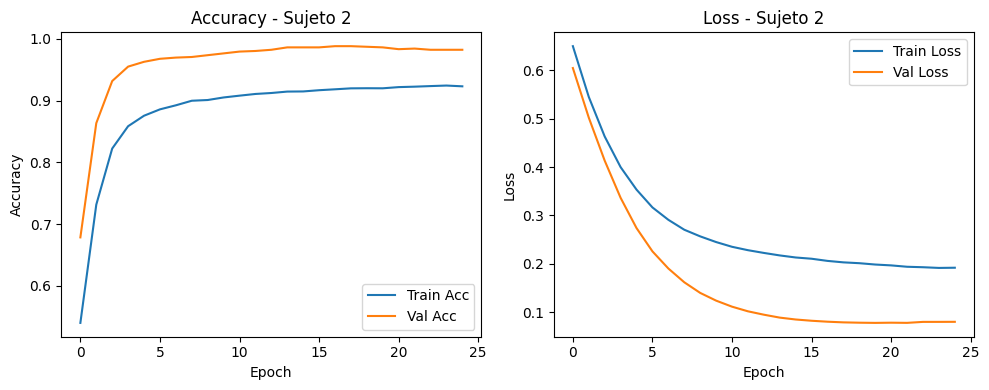

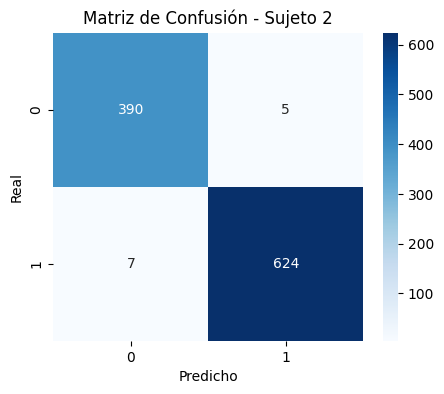

📄 Reporte de clasificación - Sujeto 2
              precision    recall  f1-score   support

           0     0.9824    0.9873    0.9848       395
           1     0.9921    0.9889    0.9905       631

    accuracy                         0.9883      1026
   macro avg     0.9872    0.9881    0.9877      1026
weighted avg     0.9883    0.9883    0.9883      1026


🧪 Validando grupo 3 de 37
Clases en test (sujeto 3): {0: 394, 1: 637}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6454 - accuracy: 0.6841 - val_loss: 0.6141 - val_accuracy: 0.7187

Epoch 00001: val_accuracy improved from -inf to 0.71872, saving model to modelos\mejor_modelo_3.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5687 - accuracy: 0.7921 - val_loss: 0.5510 - val_accuracy: 0.7585

Epoch 00002: val_accuracy improved from 0.71872 to 0.75849, saving model to modelos\mejor_modelo_3.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4

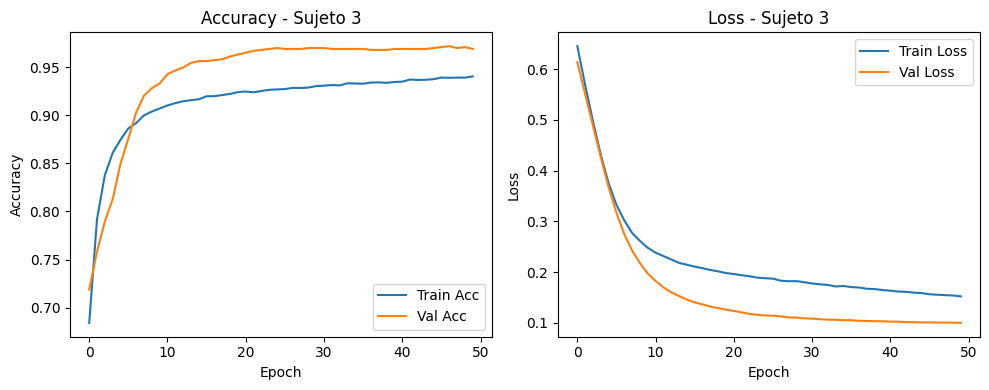

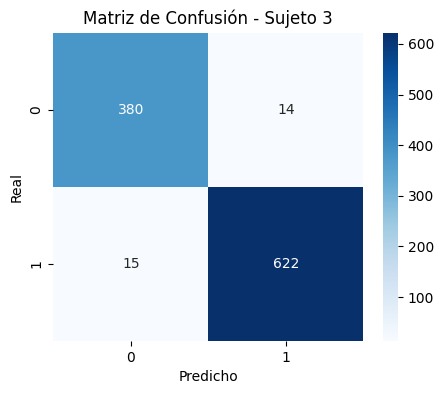

📄 Reporte de clasificación - Sujeto 3
              precision    recall  f1-score   support

           0     0.9620    0.9645    0.9632       394
           1     0.9780    0.9765    0.9772       637

    accuracy                         0.9719      1031
   macro avg     0.9700    0.9705    0.9702      1031
weighted avg     0.9719    0.9719    0.9719      1031


🧪 Validando grupo 4 de 37
Clases en test (sujeto 4): {0: 396, 1: 648}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6498 - accuracy: 0.6502 - val_loss: 0.6421 - val_accuracy: 0.7088

Epoch 00001: val_accuracy improved from -inf to 0.70881, saving model to modelos\mejor_modelo_4.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5823 - accuracy: 0.7660 - val_loss: 0.5803 - val_accuracy: 0.7816

Epoch 00002: val_accuracy improved from 0.70881 to 0.78161, saving model to modelos\mejor_modelo_4.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

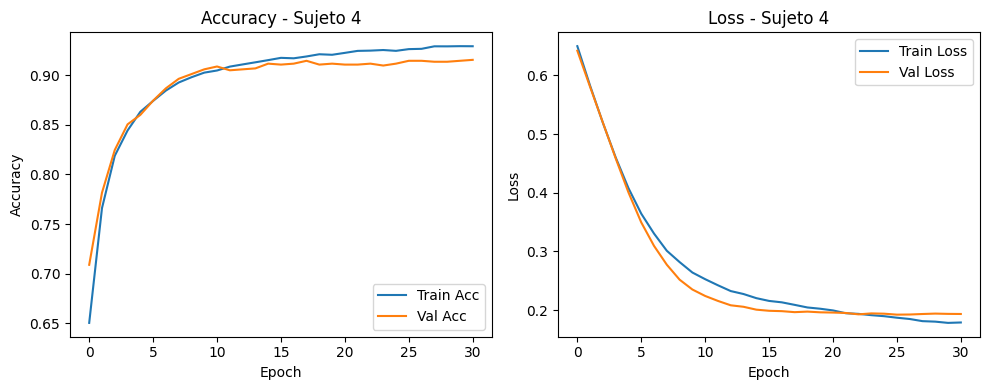

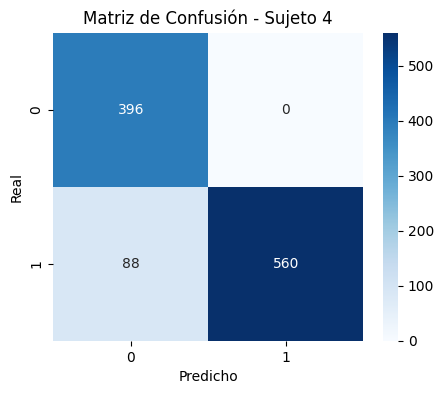

📄 Reporte de clasificación - Sujeto 4
              precision    recall  f1-score   support

           0     0.8182    1.0000    0.9000       396
           1     1.0000    0.8642    0.9272       648

    accuracy                         0.9157      1044
   macro avg     0.9091    0.9321    0.9136      1044
weighted avg     0.9310    0.9157    0.9169      1044


🧪 Validando grupo 5 de 37
Clases en test (sujeto 5): {0: 395, 1: 600}
Epoch 1/50
415/415 [==============================] - 2s 4ms/step - loss: 0.6346 - accuracy: 0.6406 - val_loss: 0.5643 - val_accuracy: 0.7910

Epoch 00001: val_accuracy improved from -inf to 0.79095, saving model to modelos\mejor_modelo_5.h5
Epoch 2/50
415/415 [==============================] - 1s 3ms/step - loss: 0.5458 - accuracy: 0.7708 - val_loss: 0.4399 - val_accuracy: 0.9286

Epoch 00002: val_accuracy improved from 0.79095 to 0.92864, saving model to modelos\mejor_modelo_5.h5
Epoch 3/50
415/415 [==============================] - 1s 3ms/step - loss: 0.4

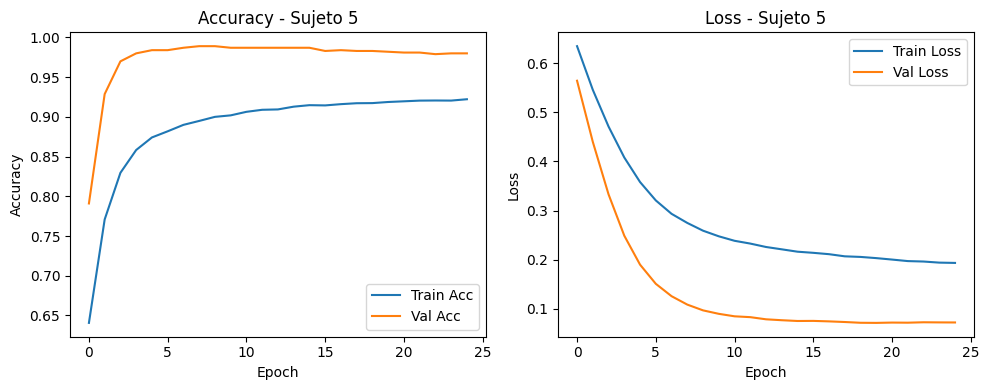

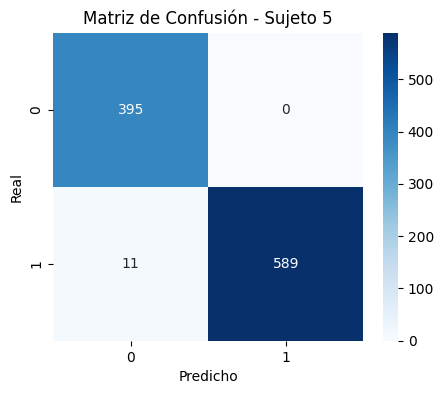

📄 Reporte de clasificación - Sujeto 5
              precision    recall  f1-score   support

           0     0.9729    1.0000    0.9863       395
           1     1.0000    0.9817    0.9907       600

    accuracy                         0.9889       995
   macro avg     0.9865    0.9908    0.9885       995
weighted avg     0.9892    0.9889    0.9890       995


🧪 Validando grupo 6 de 37
Clases en test (sujeto 6): {0: 396, 1: 632}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6834 - accuracy: 0.6437 - val_loss: 0.6350 - val_accuracy: 0.6304

Epoch 00001: val_accuracy improved from -inf to 0.63035, saving model to modelos\mejor_modelo_6.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6067 - accuracy: 0.7617 - val_loss: 0.5979 - val_accuracy: 0.7296

Epoch 00002: val_accuracy improved from 0.63035 to 0.72957, saving model to modelos\mejor_modelo_6.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

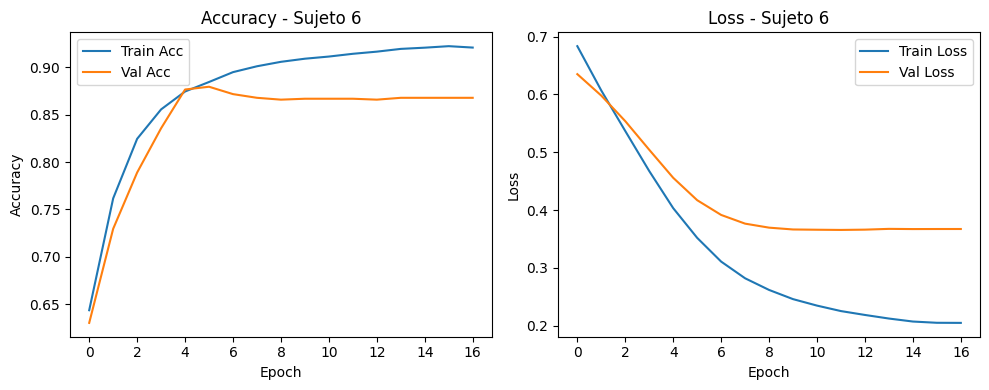

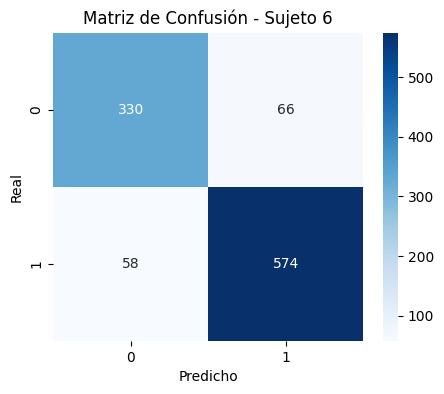

📄 Reporte de clasificación - Sujeto 6
              precision    recall  f1-score   support

           0     0.8505    0.8333    0.8418       396
           1     0.8969    0.9082    0.9025       632

    accuracy                         0.8794      1028
   macro avg     0.8737    0.8708    0.8722      1028
weighted avg     0.8790    0.8794    0.8791      1028


🧪 Validando grupo 7 de 37
Clases en test (sujeto 7): {0: 399, 1: 666}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6527 - accuracy: 0.6783 - val_loss: 0.6061 - val_accuracy: 0.7127

Epoch 00001: val_accuracy improved from -inf to 0.71268, saving model to modelos\mejor_modelo_7.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5724 - accuracy: 0.7768 - val_loss: 0.5322 - val_accuracy: 0.7709

Epoch 00002: val_accuracy improved from 0.71268 to 0.77089, saving model to modelos\mejor_modelo_7.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

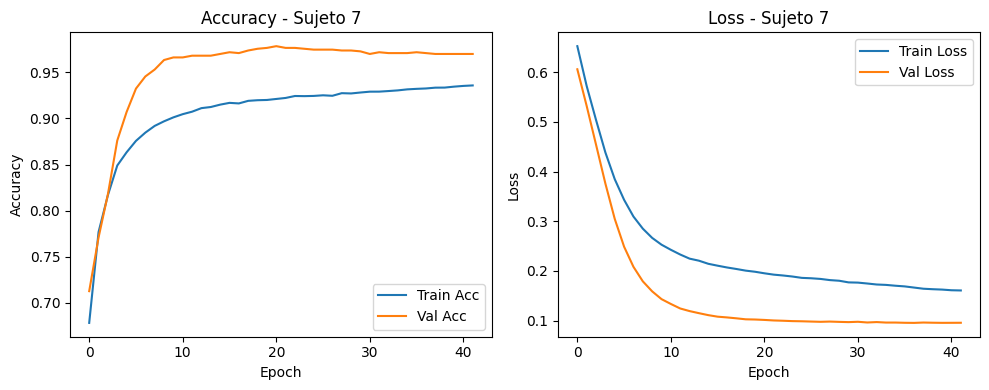

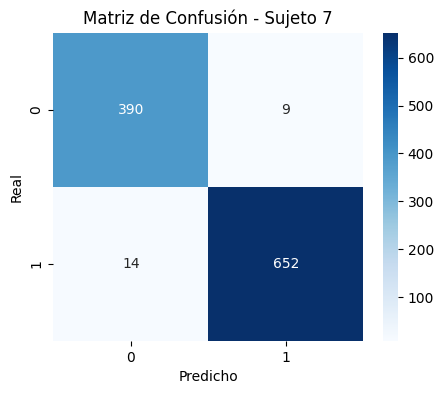

📄 Reporte de clasificación - Sujeto 7
              precision    recall  f1-score   support

           0     0.9653    0.9774    0.9714       399
           1     0.9864    0.9790    0.9827       666

    accuracy                         0.9784      1065
   macro avg     0.9759    0.9782    0.9770      1065
weighted avg     0.9785    0.9784    0.9784      1065


🧪 Validando grupo 8 de 37
Clases en test (sujeto 8): {0: 396, 1: 647}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6419 - accuracy: 0.5983 - val_loss: 0.5807 - val_accuracy: 0.7258

Epoch 00001: val_accuracy improved from -inf to 0.72579, saving model to modelos\mejor_modelo_8.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5704 - accuracy: 0.7304 - val_loss: 0.4975 - val_accuracy: 0.8332

Epoch 00002: val_accuracy improved from 0.72579 to 0.83317, saving model to modelos\mejor_modelo_8.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

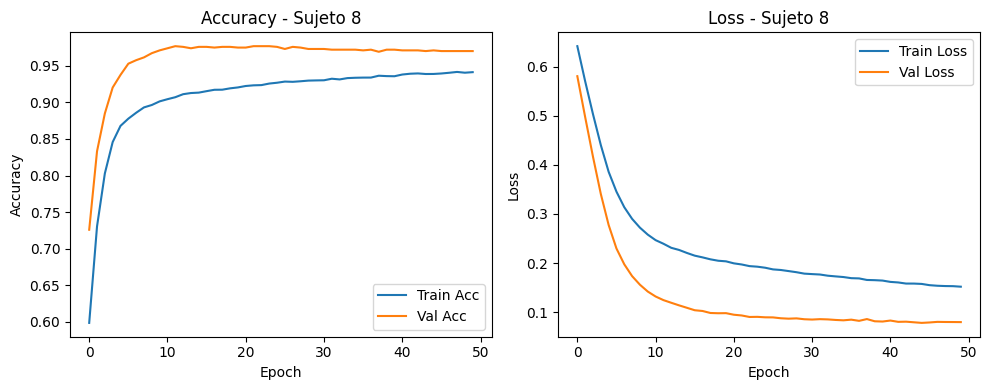

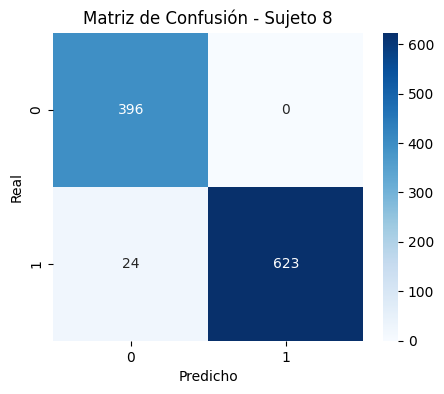

📄 Reporte de clasificación - Sujeto 8
              precision    recall  f1-score   support

           0     0.9429    1.0000    0.9706       396
           1     1.0000    0.9629    0.9811       647

    accuracy                         0.9770      1043
   macro avg     0.9714    0.9815    0.9758      1043
weighted avg     0.9783    0.9770    0.9771      1043


🧪 Validando grupo 9 de 37
Clases en test (sujeto 9): {0: 396, 1: 650}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.7009 - accuracy: 0.5721 - val_loss: 0.6088 - val_accuracy: 0.8212

Epoch 00001: val_accuracy improved from -inf to 0.82122, saving model to modelos\mejor_modelo_9.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6065 - accuracy: 0.7545 - val_loss: 0.5150 - val_accuracy: 0.9015

Epoch 00002: val_accuracy improved from 0.82122 to 0.90153, saving model to modelos\mejor_modelo_9.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5

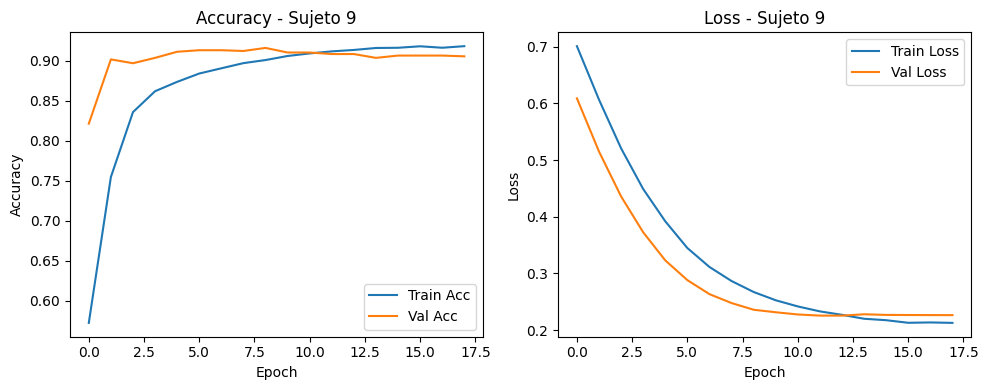

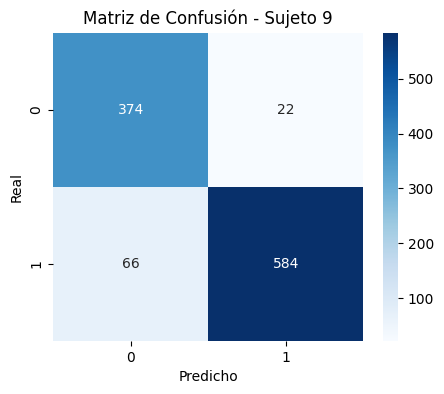

📄 Reporte de clasificación - Sujeto 9
              precision    recall  f1-score   support

           0     0.8500    0.9444    0.8947       396
           1     0.9637    0.8985    0.9299       650

    accuracy                         0.9159      1046
   macro avg     0.9068    0.9215    0.9123      1046
weighted avg     0.9207    0.9159    0.9166      1046


🧪 Validando grupo 10 de 37
Clases en test (sujeto 10): {0: 396, 1: 718}
Epoch 1/50
413/413 [==============================] - 2s 3ms/step - loss: 0.6600 - accuracy: 0.6557 - val_loss: 0.5950 - val_accuracy: 0.8052

Epoch 00001: val_accuracy improved from -inf to 0.80521, saving model to modelos\mejor_modelo_10.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5950 - accuracy: 0.7579 - val_loss: 0.5132 - val_accuracy: 0.8941

Epoch 00002: val_accuracy improved from 0.80521 to 0.89408, saving model to modelos\mejor_modelo_10.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss:

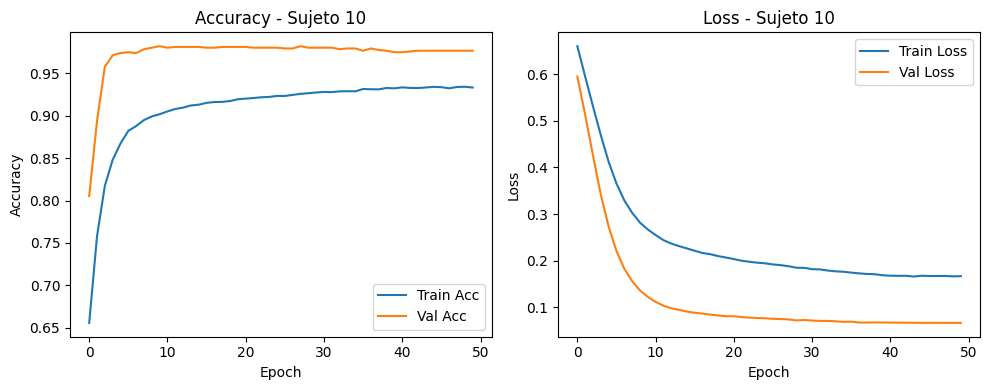

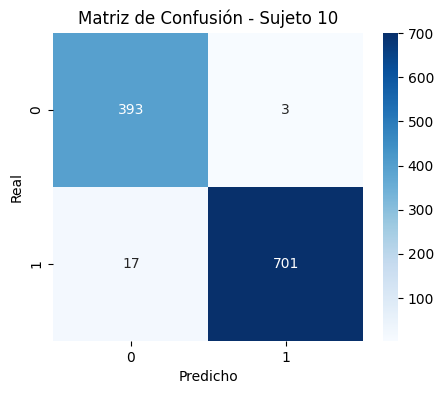

📄 Reporte de clasificación - Sujeto 10
              precision    recall  f1-score   support

           0     0.9585    0.9924    0.9752       396
           1     0.9957    0.9763    0.9859       718

    accuracy                         0.9820      1114
   macro avg     0.9771    0.9844    0.9806      1114
weighted avg     0.9825    0.9820    0.9821      1114


🧪 Validando grupo 11 de 37
Clases en test (sujeto 11): {0: 401, 1: 653}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6650 - accuracy: 0.5938 - val_loss: 0.6416 - val_accuracy: 0.6376

Epoch 00001: val_accuracy improved from -inf to 0.63757, saving model to modelos\mejor_modelo_11.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5702 - accuracy: 0.7536 - val_loss: 0.6107 - val_accuracy: 0.6414

Epoch 00002: val_accuracy improved from 0.63757 to 0.64137, saving model to modelos\mejor_modelo_11.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

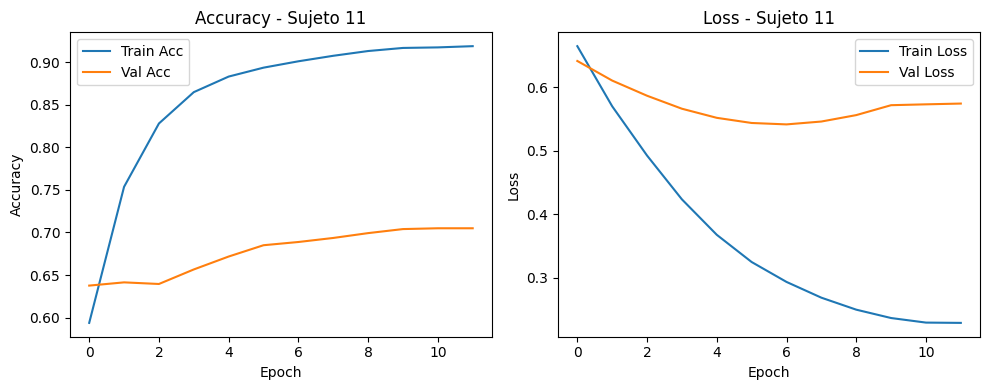

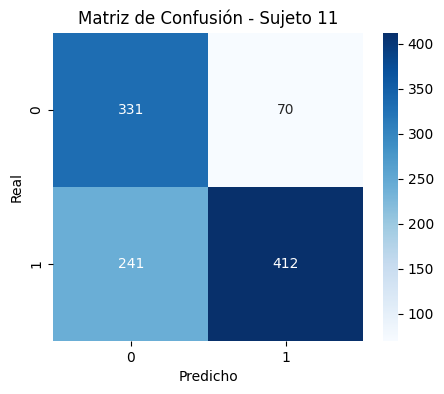

📄 Reporte de clasificación - Sujeto 11
              precision    recall  f1-score   support

           0     0.5787    0.8254    0.6804       401
           1     0.8548    0.6309    0.7260       653

    accuracy                         0.7049      1054
   macro avg     0.7167    0.7282    0.7032      1054
weighted avg     0.7497    0.7049    0.7086      1054


🧪 Validando grupo 12 de 37
Clases en test (sujeto 12): {0: 410, 1: 682}
Epoch 1/50
413/413 [==============================] - 2s 4ms/step - loss: 0.6925 - accuracy: 0.5787 - val_loss: 0.5758 - val_accuracy: 0.8764

Epoch 00001: val_accuracy improved from -inf to 0.87637, saving model to modelos\mejor_modelo_12.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.6042 - accuracy: 0.7351 - val_loss: 0.4667 - val_accuracy: 0.9579

Epoch 00002: val_accuracy improved from 0.87637 to 0.95788, saving model to modelos\mejor_modelo_12.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

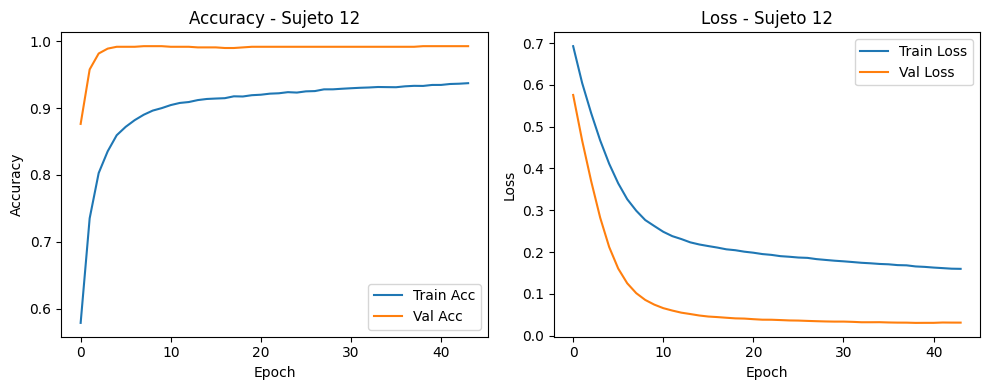

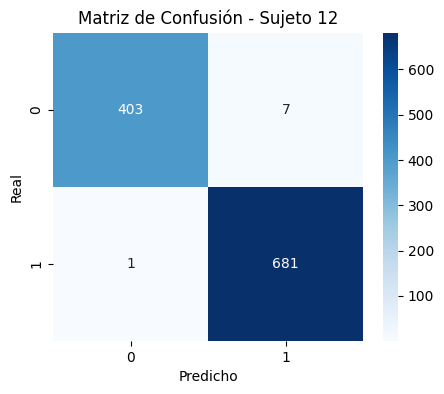

📄 Reporte de clasificación - Sujeto 12
              precision    recall  f1-score   support

           0     0.9975    0.9829    0.9902       410
           1     0.9898    0.9985    0.9942       682

    accuracy                         0.9927      1092
   macro avg     0.9937    0.9907    0.9922      1092
weighted avg     0.9927    0.9927    0.9927      1092


🧪 Validando grupo 13 de 37
Clases en test (sujeto 13): {0: 400, 1: 732}
Epoch 1/50
413/413 [==============================] - 2s 3ms/step - loss: 0.6423 - accuracy: 0.6923 - val_loss: 0.5679 - val_accuracy: 0.8101

Epoch 00001: val_accuracy improved from -inf to 0.81007, saving model to modelos\mejor_modelo_13.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5691 - accuracy: 0.7844 - val_loss: 0.4831 - val_accuracy: 0.9320

Epoch 00002: val_accuracy improved from 0.81007 to 0.93198, saving model to modelos\mejor_modelo_13.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

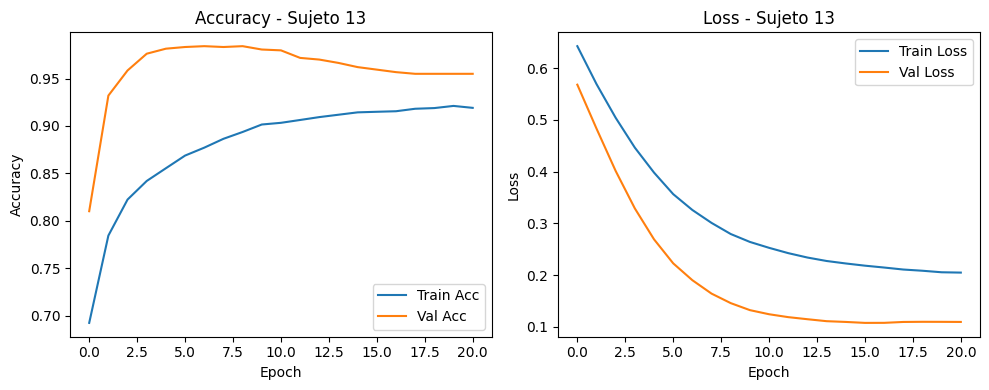

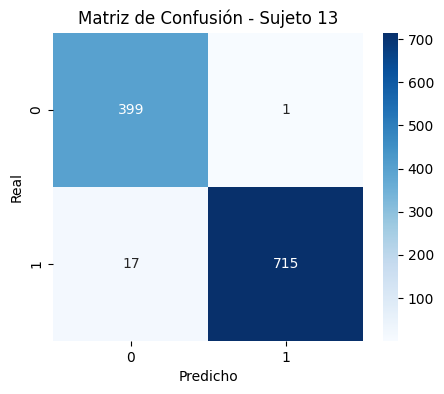

📄 Reporte de clasificación - Sujeto 13
              precision    recall  f1-score   support

           0     0.9591    0.9975    0.9779       400
           1     0.9986    0.9768    0.9876       732

    accuracy                         0.9841      1132
   macro avg     0.9789    0.9871    0.9828      1132
weighted avg     0.9847    0.9841    0.9842      1132


🧪 Validando grupo 14 de 37
Clases en test (sujeto 14): {0: 401, 1: 647}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6593 - accuracy: 0.6229 - val_loss: 0.5574 - val_accuracy: 0.8721

Epoch 00001: val_accuracy improved from -inf to 0.87214, saving model to modelos\mejor_modelo_14.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5734 - accuracy: 0.7690 - val_loss: 0.4530 - val_accuracy: 0.9456

Epoch 00002: val_accuracy improved from 0.87214 to 0.94561, saving model to modelos\mejor_modelo_14.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

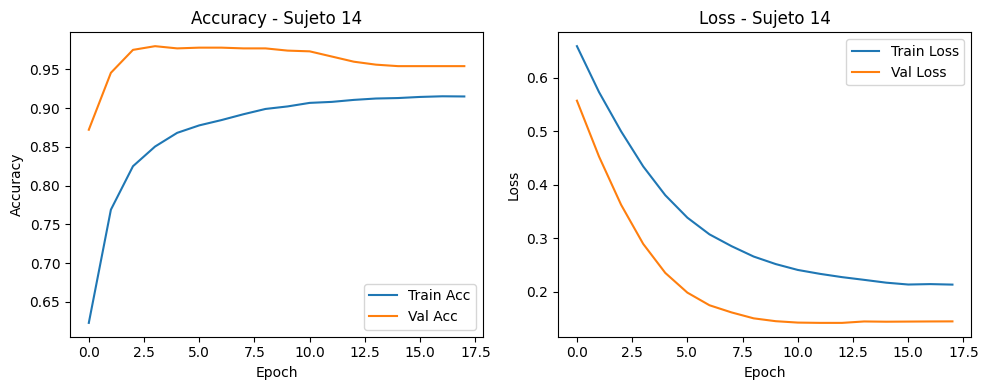

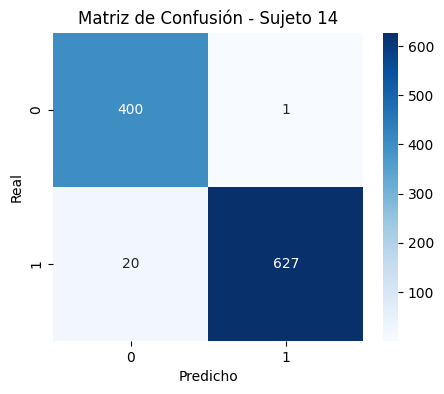

📄 Reporte de clasificación - Sujeto 14
              precision    recall  f1-score   support

           0     0.9524    0.9975    0.9744       401
           1     0.9984    0.9691    0.9835       647

    accuracy                         0.9800      1048
   macro avg     0.9754    0.9833    0.9790      1048
weighted avg     0.9808    0.9800    0.9800      1048


🧪 Validando grupo 15 de 37
Clases en test (sujeto 15): {0: 397, 1: 638}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6284 - accuracy: 0.6538 - val_loss: 0.5636 - val_accuracy: 0.7855

Epoch 00001: val_accuracy improved from -inf to 0.78551, saving model to modelos\mejor_modelo_15.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5454 - accuracy: 0.7705 - val_loss: 0.4522 - val_accuracy: 0.8686

Epoch 00002: val_accuracy improved from 0.78551 to 0.86860, saving model to modelos\mejor_modelo_15.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

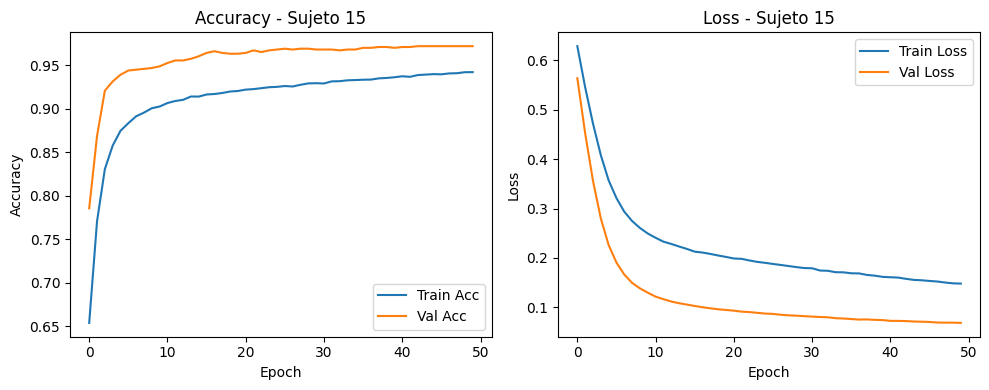

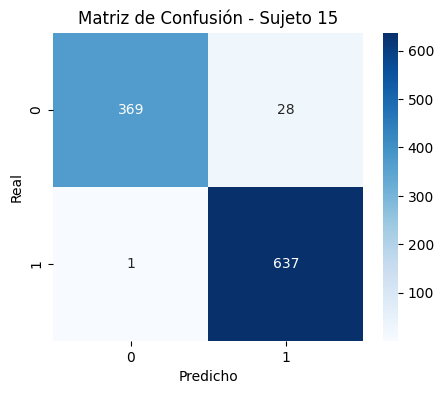

📄 Reporte de clasificación - Sujeto 15
              precision    recall  f1-score   support

           0     0.9973    0.9295    0.9622       397
           1     0.9579    0.9984    0.9777       638

    accuracy                         0.9720      1035
   macro avg     0.9776    0.9640    0.9700      1035
weighted avg     0.9730    0.9720    0.9718      1035


🧪 Validando grupo 16 de 37
Clases en test (sujeto 16): {0: 393, 1: 664}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6316 - accuracy: 0.6835 - val_loss: 0.7184 - val_accuracy: 0.4418

Epoch 00001: val_accuracy improved from -inf to 0.44182, saving model to modelos\mejor_modelo_16.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5399 - accuracy: 0.7911 - val_loss: 0.7514 - val_accuracy: 0.4219

Epoch 00002: val_accuracy did not improve from 0.44182
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss: 0.4654 - accuracy: 0.8457 - val_loss: 0.7821 -

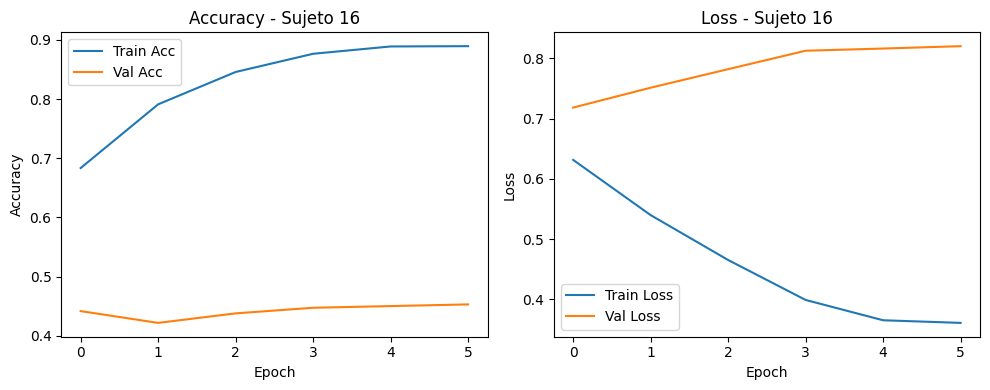

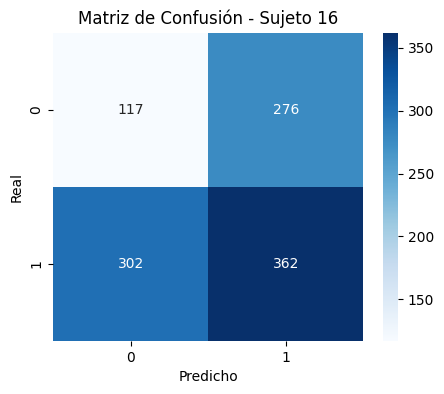

📄 Reporte de clasificación - Sujeto 16
              precision    recall  f1-score   support

           0     0.2792    0.2977    0.2882       393
           1     0.5674    0.5452    0.5561       664

    accuracy                         0.4532      1057
   macro avg     0.4233    0.4214    0.4221      1057
weighted avg     0.4603    0.4532    0.4565      1057


🧪 Validando grupo 17 de 37
Clases en test (sujeto 17): {0: 396, 1: 658}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6891 - accuracy: 0.5834 - val_loss: 0.6327 - val_accuracy: 0.6803

Epoch 00001: val_accuracy improved from -inf to 0.68027, saving model to modelos\mejor_modelo_17.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5958 - accuracy: 0.7127 - val_loss: 0.5489 - val_accuracy: 0.7628

Epoch 00002: val_accuracy improved from 0.68027 to 0.76281, saving model to modelos\mejor_modelo_17.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

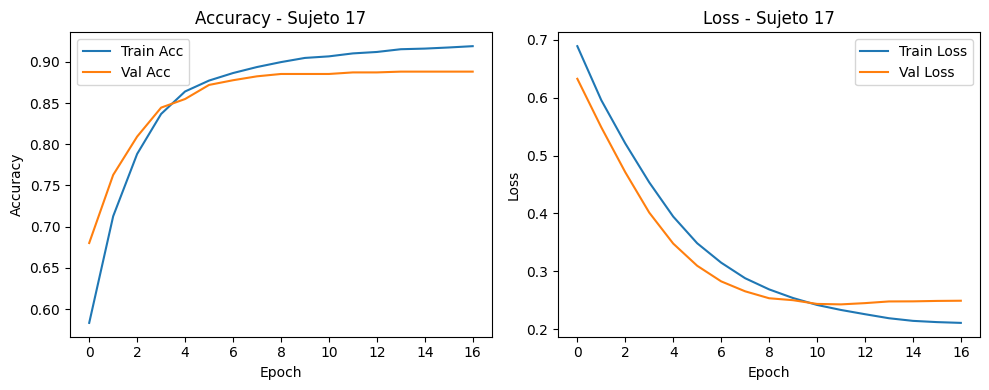

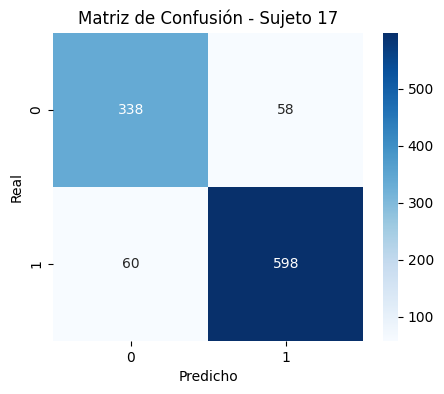

📄 Reporte de clasificación - Sujeto 17
              precision    recall  f1-score   support

           0     0.8492    0.8535    0.8514       396
           1     0.9116    0.9088    0.9102       658

    accuracy                         0.8880      1054
   macro avg     0.8804    0.8812    0.8808      1054
weighted avg     0.8882    0.8880    0.8881      1054


🧪 Validando grupo 18 de 37
Clases en test (sujeto 18): {0: 395, 1: 705}
Epoch 1/50
413/413 [==============================] - 2s 3ms/step - loss: 0.6824 - accuracy: 0.5797 - val_loss: 0.6682 - val_accuracy: 0.6018

Epoch 00001: val_accuracy improved from -inf to 0.60182, saving model to modelos\mejor_modelo_18.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.5836 - accuracy: 0.7451 - val_loss: 0.6335 - val_accuracy: 0.6309

Epoch 00002: val_accuracy improved from 0.60182 to 0.63091, saving model to modelos\mejor_modelo_18.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

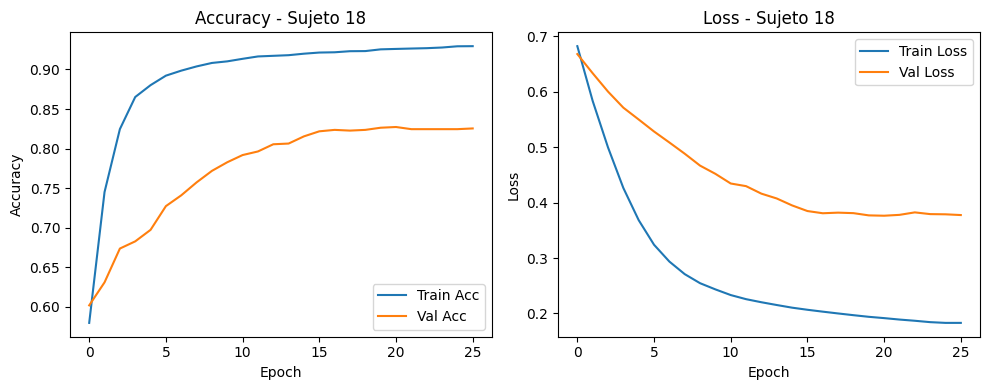

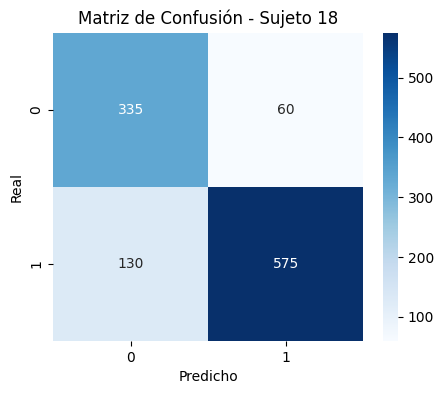

📄 Reporte de clasificación - Sujeto 18
              precision    recall  f1-score   support

           0     0.7204    0.8481    0.7791       395
           1     0.9055    0.8156    0.8582       705

    accuracy                         0.8273      1100
   macro avg     0.8130    0.8319    0.8186      1100
weighted avg     0.8391    0.8273    0.8298      1100


🧪 Validando grupo 19 de 37
Clases en test (sujeto 19): {0: 396, 1: 663}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6607 - accuracy: 0.6542 - val_loss: 0.6626 - val_accuracy: 0.5968

Epoch 00001: val_accuracy improved from -inf to 0.59679, saving model to modelos\mejor_modelo_19.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5730 - accuracy: 0.7590 - val_loss: 0.6555 - val_accuracy: 0.6043

Epoch 00002: val_accuracy improved from 0.59679 to 0.60434, saving model to modelos\mejor_modelo_19.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

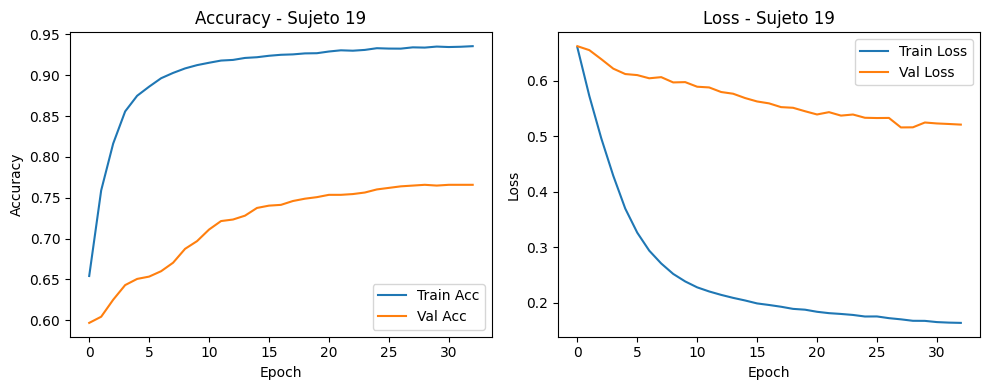

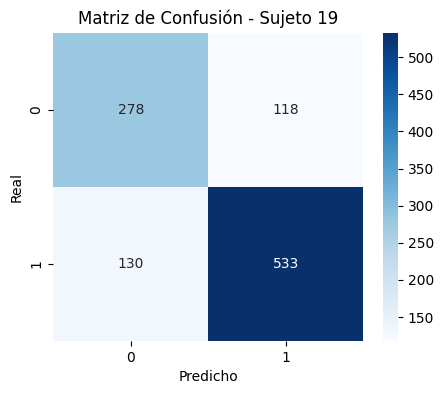

📄 Reporte de clasificación - Sujeto 19
              precision    recall  f1-score   support

           0     0.6814    0.7020    0.6915       396
           1     0.8187    0.8039    0.8113       663

    accuracy                         0.7658      1059
   macro avg     0.7501    0.7530    0.7514      1059
weighted avg     0.7674    0.7658    0.7665      1059


🧪 Validando grupo 20 de 37
Clases en test (sujeto 20): {0: 396, 1: 707}
Epoch 1/50
413/413 [==============================] - 3s 4ms/step - loss: 0.6907 - accuracy: 0.5253 - val_loss: 0.6157 - val_accuracy: 0.7189

Epoch 00001: val_accuracy improved from -inf to 0.71895, saving model to modelos\mejor_modelo_20.h5
Epoch 2/50
413/413 [==============================] - 1s 3ms/step - loss: 0.6069 - accuracy: 0.6943 - val_loss: 0.5257 - val_accuracy: 0.8277

Epoch 00002: val_accuracy improved from 0.71895 to 0.82774, saving model to modelos\mejor_modelo_20.h5
Epoch 3/50
413/413 [==============================] - 1s 3ms/step - loss

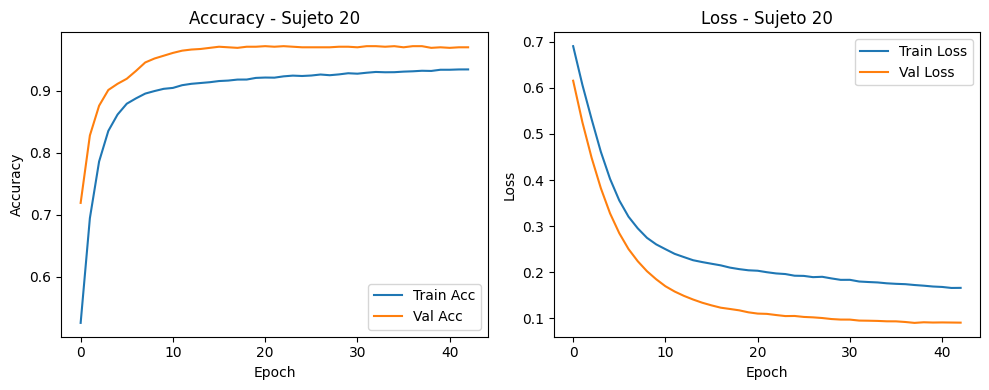

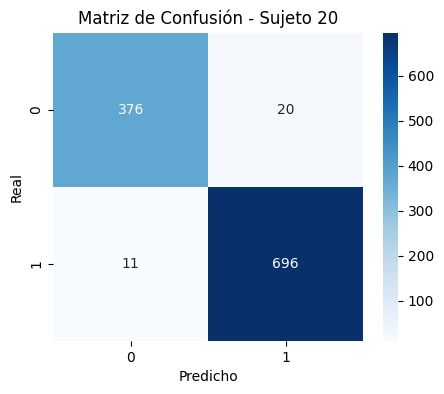

📄 Reporte de clasificación - Sujeto 20
              precision    recall  f1-score   support

           0     0.9716    0.9495    0.9604       396
           1     0.9721    0.9844    0.9782       707

    accuracy                         0.9719      1103
   macro avg     0.9718    0.9670    0.9693      1103
weighted avg     0.9719    0.9719    0.9718      1103


🧪 Validando grupo 21 de 37
Clases en test (sujeto 21): {0: 395, 1: 661}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6855 - accuracy: 0.5758 - val_loss: 0.6495 - val_accuracy: 0.6345

Epoch 00001: val_accuracy improved from -inf to 0.63447, saving model to modelos\mejor_modelo_21.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5879 - accuracy: 0.7471 - val_loss: 0.5664 - val_accuracy: 0.7765

Epoch 00002: val_accuracy improved from 0.63447 to 0.77652, saving model to modelos\mejor_modelo_21.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

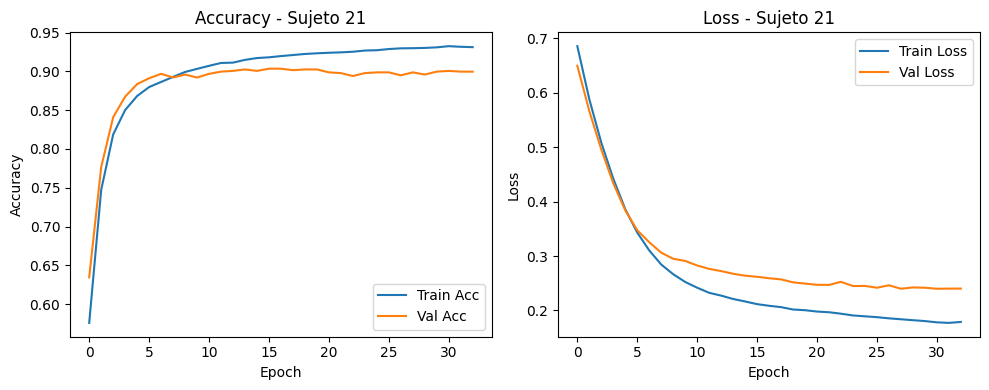

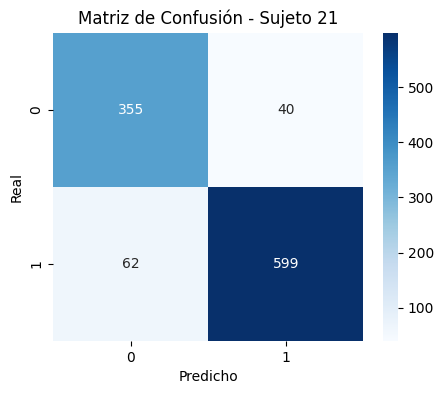

📄 Reporte de clasificación - Sujeto 21
              precision    recall  f1-score   support

           0     0.8513    0.8987    0.8744       395
           1     0.9374    0.9062    0.9215       661

    accuracy                         0.9034      1056
   macro avg     0.8944    0.9025    0.8980      1056
weighted avg     0.9052    0.9034    0.9039      1056


🧪 Validando grupo 22 de 37
Clases en test (sujeto 22): {0: 395, 1: 668}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6145 - accuracy: 0.6890 - val_loss: 0.5642 - val_accuracy: 0.8495

Epoch 00001: val_accuracy improved from -inf to 0.84948, saving model to modelos\mejor_modelo_22.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5410 - accuracy: 0.7760 - val_loss: 0.4710 - val_accuracy: 0.9351

Epoch 00002: val_accuracy improved from 0.84948 to 0.93509, saving model to modelos\mejor_modelo_22.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

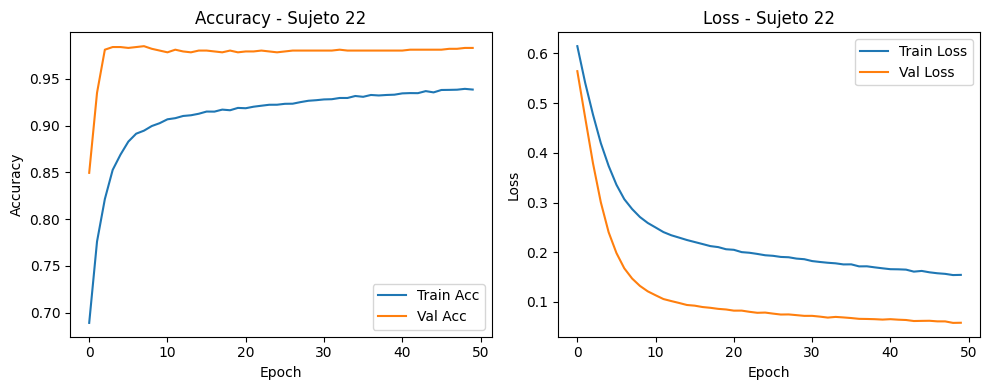

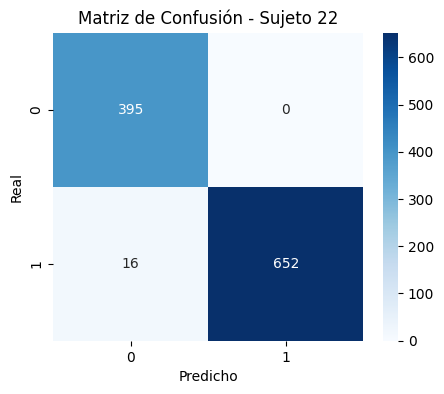

📄 Reporte de clasificación - Sujeto 22
              precision    recall  f1-score   support

           0     0.9611    1.0000    0.9801       395
           1     1.0000    0.9760    0.9879       668

    accuracy                         0.9849      1063
   macro avg     0.9805    0.9880    0.9840      1063
weighted avg     0.9855    0.9849    0.9850      1063


🧪 Validando grupo 23 de 37
Clases en test (sujeto 23): {0: 398, 1: 658}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6439 - accuracy: 0.6589 - val_loss: 0.6011 - val_accuracy: 0.7159

Epoch 00001: val_accuracy improved from -inf to 0.71591, saving model to modelos\mejor_modelo_23.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5637 - accuracy: 0.7660 - val_loss: 0.5087 - val_accuracy: 0.8106

Epoch 00002: val_accuracy improved from 0.71591 to 0.81061, saving model to modelos\mejor_modelo_23.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

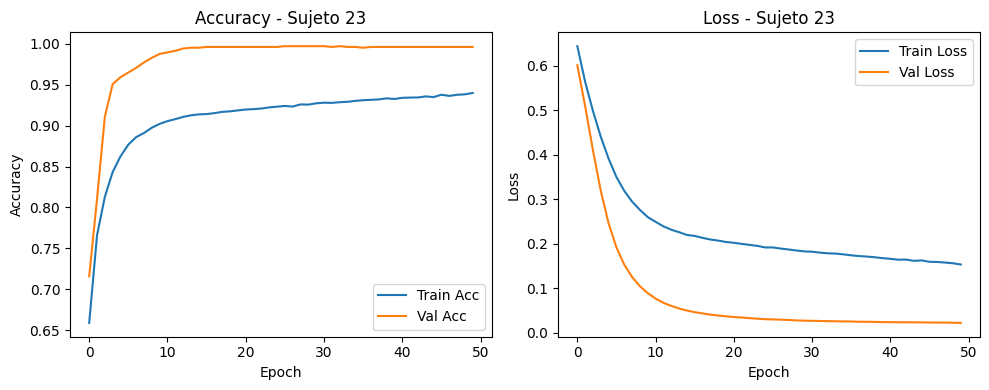

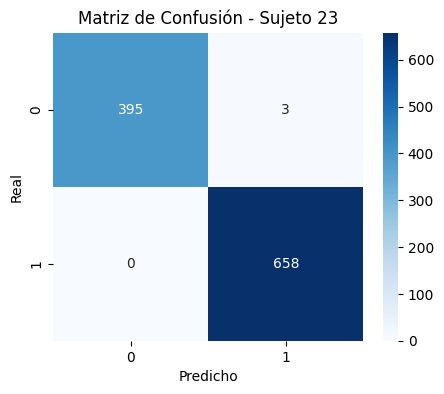

📄 Reporte de clasificación - Sujeto 23
              precision    recall  f1-score   support

           0     1.0000    0.9925    0.9962       398
           1     0.9955    1.0000    0.9977       658

    accuracy                         0.9972      1056
   macro avg     0.9977    0.9962    0.9970      1056
weighted avg     0.9972    0.9972    0.9972      1056


🧪 Validando grupo 24 de 37
Clases en test (sujeto 24): {0: 396, 1: 663}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.7272 - accuracy: 0.5533 - val_loss: 0.7364 - val_accuracy: 0.4608

Epoch 00001: val_accuracy improved from -inf to 0.46081, saving model to modelos\mejor_modelo_24.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.6383 - accuracy: 0.7009 - val_loss: 0.7271 - val_accuracy: 0.5024

Epoch 00002: val_accuracy improved from 0.46081 to 0.50236, saving model to modelos\mejor_modelo_24.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

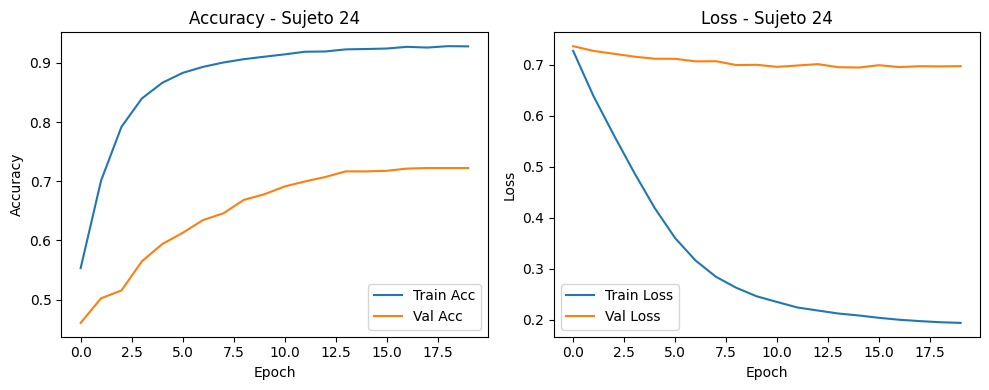

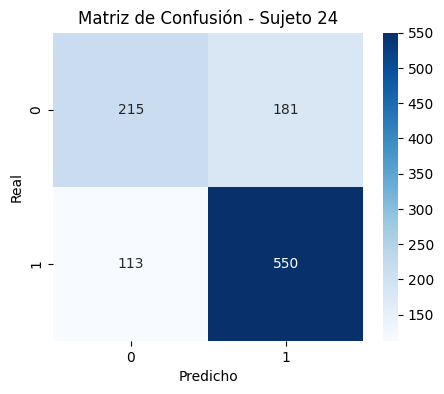

📄 Reporte de clasificación - Sujeto 24
              precision    recall  f1-score   support

           0     0.6555    0.5429    0.5939       396
           1     0.7524    0.8296    0.7891       663

    accuracy                         0.7224      1059
   macro avg     0.7039    0.6862    0.6915      1059
weighted avg     0.7162    0.7224    0.7161      1059


🧪 Validando grupo 25 de 37
Clases en test (sujeto 25): {0: 395, 1: 661}
Epoch 1/50
414/414 [==============================] - 2s 3ms/step - loss: 0.6607 - accuracy: 0.6616 - val_loss: 0.6568 - val_accuracy: 0.6269

Epoch 00001: val_accuracy improved from -inf to 0.62689, saving model to modelos\mejor_modelo_25.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5677 - accuracy: 0.7858 - val_loss: 0.6090 - val_accuracy: 0.6695

Epoch 00002: val_accuracy improved from 0.62689 to 0.66951, saving model to modelos\mejor_modelo_25.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

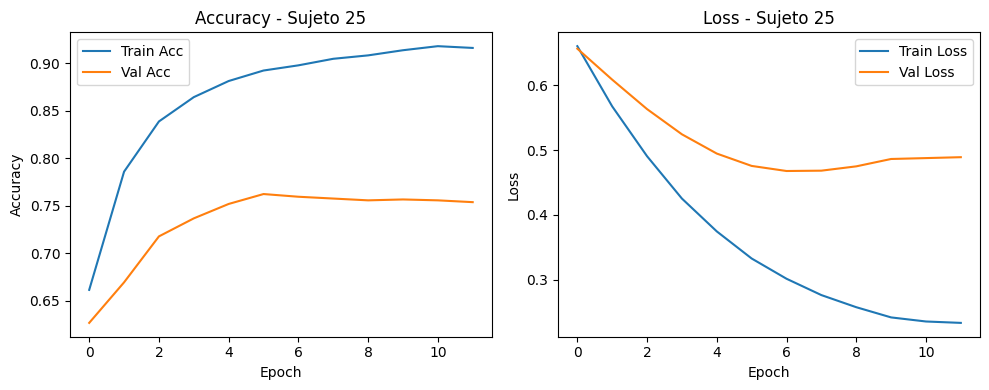

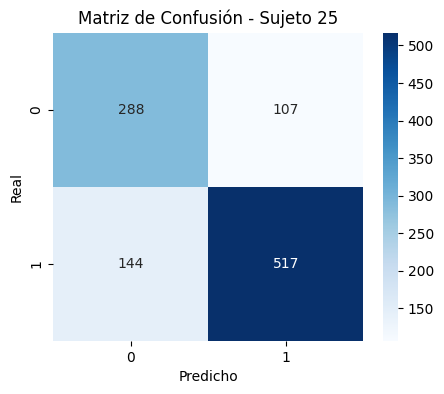

📄 Reporte de clasificación - Sujeto 25
              precision    recall  f1-score   support

           0     0.6667    0.7291    0.6965       395
           1     0.8285    0.7821    0.8047       661

    accuracy                         0.7623      1056
   macro avg     0.7476    0.7556    0.7506      1056
weighted avg     0.7680    0.7623    0.7642      1056


🧪 Validando grupo 26 de 37
Clases en test (sujeto 26): {0: 395, 1: 647}
Epoch 1/50
414/414 [==============================] - 2s 4ms/step - loss: 0.6692 - accuracy: 0.6319 - val_loss: 0.6063 - val_accuracy: 0.7351

Epoch 00001: val_accuracy improved from -inf to 0.73512, saving model to modelos\mejor_modelo_26.h5
Epoch 2/50
414/414 [==============================] - 1s 3ms/step - loss: 0.5910 - accuracy: 0.7497 - val_loss: 0.5309 - val_accuracy: 0.8081

Epoch 00002: val_accuracy improved from 0.73512 to 0.80806, saving model to modelos\mejor_modelo_26.h5
Epoch 3/50
414/414 [==============================] - 1s 3ms/step - loss

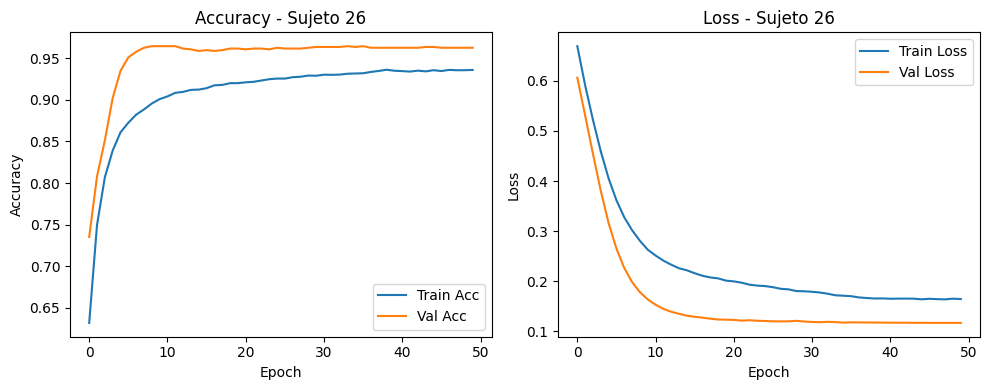

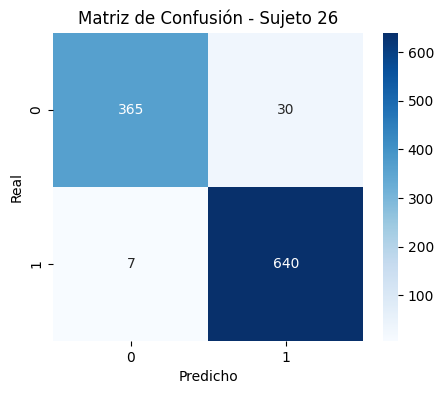

📄 Reporte de clasificación - Sujeto 26
              precision    recall  f1-score   support

           0     0.9812    0.9241    0.9518       395
           1     0.9552    0.9892    0.9719       647

    accuracy                         0.9645      1042
   macro avg     0.9682    0.9566    0.9618      1042
weighted avg     0.9651    0.9645    0.9643      1042


📊 Resultados Finales:
Promedio Accuracy: 0.8991 ± 0.1249
Promedio F1 Score: 0.9171 ± 0.1030

🔍 Análisis Train vs Val:
Diferencia promedio (Val - Train): -0.0362 ± 0.1156
Folds donde Val > Train: 14/26


In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D

accuracies = []
f1_scores = []
train_val_diffs = []  # 🆕 Para analizar diferencias

logo = LeaveOneGroupOut()
split_num = 1

for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):
    print(f"\n🧪 Validando grupo {split_num} de {len(np.unique(subjects))}")
    X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    y_train, y_test = y_seq[train_idx], y_seq[test_idx]

    X_train = tf.cast(X_train, tf.float32)
    X_test = tf.cast(X_test, tf.float32)
    y_train = tf.cast(y_train, tf.int32)
    y_test = tf.cast(y_test, tf.int32)

    checkpoint = ModelCheckpoint(f"modelos/mejor_modelo_{split_num}.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-8, verbose=1)
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train.numpy()), y=y_train.numpy())
    class_weight_dict = dict(zip(np.unique(y_train.numpy()), class_weights))

    unique, counts = np.unique(y_test, return_counts=True)
    print(f"Clases en test (sujeto {split_num}): {dict(zip(unique, counts))}")

    # 🔄 Modelo con menos regularización
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(10, 52)),
        MaxPooling1D(2),
        LSTM(32, kernel_regularizer=tf.keras.regularizers.l2(1e-5)),  # 🔄 Menos regularización
        Dropout(0.3),  # 🔄 Menos dropout
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1.0e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )


    with tf.device('/GPU:0'):
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=64,
            validation_data=(X_test, y_test),
            callbacks=[checkpoint, reduce_lr, early_stop],
            class_weight=class_weight_dict,
            verbose=1
        )

    # Evaluar
    mejor_modelo = load_model(f"modelos/mejor_modelo_{split_num}.h5")
    loss, acc = mejor_modelo.evaluate(X_test, y_test, verbose=0)
    y_pred_prob = mejor_modelo.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    f1 = f1_score(y_test, y_pred)
    accuracies.append(acc)
    f1_scores.append(f1)

    # 🆕 Encontrar en qué epoch se guardó el mejor modelo
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_val_acc = max(history.history['val_accuracy'])
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_acc = history.history['accuracy'][-1]
    diff = final_val_acc - final_train_acc
    train_val_diffs.append(diff)
    
    print(f"✅ Accuracy: {acc:.4f} - F1: {f1:.4f}")
    print(f"🎯 Mejor modelo guardado en epoch {best_epoch} (Val Acc: {best_val_acc:.4f})")
    print(f"📉 Val Acc final: {final_val_acc:.4f} (diferencia: {final_val_acc - best_val_acc:+.4f})")
    print(f"📊 Train Acc: {final_train_acc:.4f} | Val Acc: {final_val_acc:.4f} | Diff: {diff:+.4f}")

    # ----------------------
    # 🔹 CURVAS DE ENTRENAMIENTO
    # ----------------------
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'Accuracy - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Loss - Sujeto {split_num}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    # plt.savefig(f'curvas_entrenamiento_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    # ----------------------
    # 🔹 MATRIZ DE CONFUSIÓN Y REPORTE
    # ----------------------
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - Sujeto {split_num}')
    plt.show()
    # plt.savefig(f'matriz_confusion_sujeto_{split_num}.png')  # Guardar imagen (opcional)

    print(f'📄 Reporte de clasificación - Sujeto {split_num}')
    print(classification_report(y_test, y_pred, digits=4))

    split_num += 1

# ----------------------
# 📊 RESULTADOS FINALES
# ----------------------
print("\n📊 Resultados Finales:")
print(f"Promedio Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Promedio F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

# 🆕 Análisis de diferencias train/val
print(f"\n🔍 Análisis Train vs Val:")
print(f"Diferencia promedio (Val - Train): {np.mean(train_val_diffs):+.4f} ± {np.std(train_val_diffs):.4f}")
print(f"Folds donde Val > Train: {sum(1 for d in train_val_diffs if d > 0)}/{len(train_val_diffs)}")

✅ Evaluando modelo 1
✅ Evaluando modelo 2
✅ Evaluando modelo 3
✅ Evaluando modelo 4
✅ Evaluando modelo 5
✅ Evaluando modelo 6
✅ Evaluando modelo 7
✅ Evaluando modelo 8
✅ Evaluando modelo 9
✅ Evaluando modelo 10
✅ Evaluando modelo 11
✅ Evaluando modelo 12
✅ Evaluando modelo 13
✅ Evaluando modelo 14
✅ Evaluando modelo 15
✅ Evaluando modelo 16
✅ Evaluando modelo 17
✅ Evaluando modelo 18
✅ Evaluando modelo 19
✅ Evaluando modelo 20
✅ Evaluando modelo 21
✅ Evaluando modelo 22
✅ Evaluando modelo 23
✅ Evaluando modelo 24
✅ Evaluando modelo 25
✅ Evaluando modelo 26

📊 Resultados por sujeto:
    Sujeto  Accuracy  F1 Score              Modelo  class_0  class_1
0        1    0.9055    0.9206   mejor_modelo_1.h5      396      652
1        2    0.9883    0.9905   mejor_modelo_2.h5      395      631
2        3    0.9719    0.9772   mejor_modelo_3.h5      394      637
3        4    0.9157    0.9272   mejor_modelo_4.h5      396      648
4        5    0.9889    0.9907   mejor_modelo_5.h5      395      6

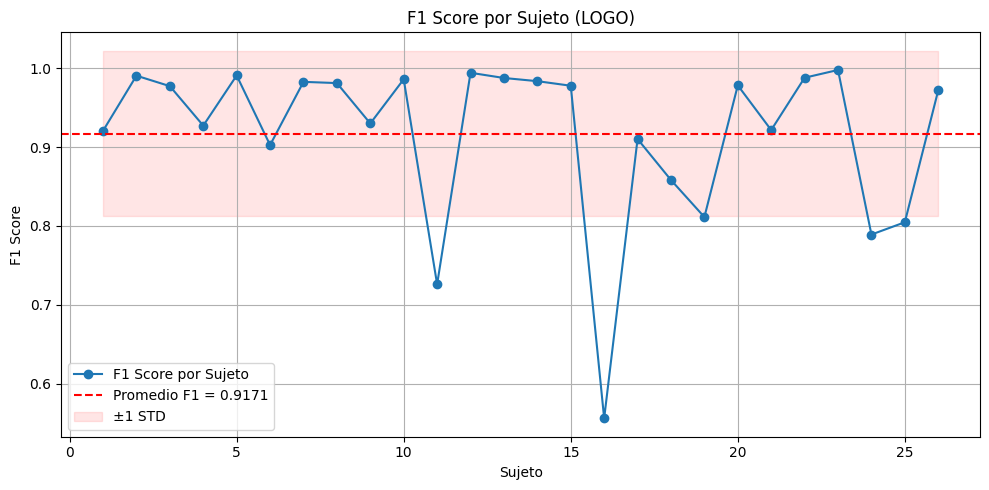


📌 Promedios generales:
Accuracy promedio: 0.8991 ± 0.1274
F1 Score promedio: 0.9171 ± 0.1051


In [15]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt

# Carpeta donde están tus modelos
MODEL_FOLDER = "modelos"
model_files = sorted([f for f in os.listdir(MODEL_FOLDER) if f.endswith(".h5")])

# Para almacenar resultados
results = []

logo = LeaveOneGroupOut()

split_num = 1
for train_idx, test_idx in logo.split(X_seq, y_seq, groups=subj_seq):
    model_path = os.path.join(MODEL_FOLDER, f"mejor_modelo_{split_num}.h5")
    if not os.path.exists(model_path):
        print(f"❌ Modelo no encontrado: {model_path}")
        split_num += 1
        continue

    print(f"✅ Evaluando modelo {split_num}")
    
    X_test = tf.cast(X_seq[test_idx], tf.float32)
    y_test = y_seq[test_idx]

    model = load_model(model_path)
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    unique, counts = np.unique(y_test, return_counts=True)
    class_dist = {f"class_{int(cls)}": int(count) for cls, count in zip(unique, counts)}

    results.append({
        "Sujeto": split_num,
        "Accuracy": acc,
        "F1 Score": f1,
        "Modelo": f"mejor_modelo_{split_num}.h5",
        **class_dist
    })

    split_num += 1

# Convertir a DataFrame
df_resultados = pd.DataFrame(results)

# -----------------------
# 🧾 Tabla resumida
# -----------------------
pd.set_option('display.float_format', lambda x: '%.4f' % x)
print("\n📊 Resultados por sujeto:")
print(df_resultados)

# -----------------------
# 📈 Gráfico resumen
# -----------------------
plt.figure(figsize=(10, 5))
plt.plot(df_resultados["Sujeto"], df_resultados["F1 Score"], marker='o', label="F1 Score por Sujeto")
plt.axhline(df_resultados["F1 Score"].mean(), color='r', linestyle='--', label=f"Promedio F1 = {df_resultados['F1 Score'].mean():.4f}")
plt.fill_between(df_resultados["Sujeto"],
                 df_resultados["F1 Score"].mean() - df_resultados["F1 Score"].std(),
                 df_resultados["F1 Score"].mean() + df_resultados["F1 Score"].std(),
                 color='r', alpha=0.1, label="±1 STD")

plt.title("F1 Score por Sujeto (LOGO)")
plt.xlabel("Sujeto")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------
# 🔢 Promedios generales
# -----------------------
print("\n📌 Promedios generales:")
print(f"Accuracy promedio: {df_resultados['Accuracy'].mean():.4f} ± {df_resultados['Accuracy'].std():.4f}")
print(f"F1 Score promedio: {df_resultados['F1 Score'].mean():.4f} ± {df_resultados['F1 Score'].std():.4f}")


In [16]:
# 📈 Análisis estadístico detallado
print("\n" + "="*60)
print("📈 ANÁLISIS ESTADÍSTICO DETALLADO")
print("="*60)

# Estadísticas por métrica
accuracy_stats = df_resultados['Accuracy'].describe()
f1_stats = df_resultados['F1 Score'].describe()

print(f"\n🎯 Estadísticas de Accuracy:")
print(f"   • Mínimo: {accuracy_stats['min']:.4f}")
print(f"   • Q1 (25%): {accuracy_stats['25%']:.4f}")
print(f"   • Mediana: {accuracy_stats['50%']:.4f}")
print(f"   • Q3 (75%): {accuracy_stats['75%']:.4f}")
print(f"   • Máximo: {accuracy_stats['max']:.4f}")
print(f"   • Desviación estándar: {accuracy_stats['std']:.4f}")

print(f"\n🎯 Estadísticas de F1 Score:")
print(f"   • Mínimo: {f1_stats['min']:.4f}")
print(f"   • Q1 (25%): {f1_stats['25%']:.4f}")
print(f"   • Mediana: {f1_stats['50%']:.4f}")
print(f"   • Q3 (75%): {f1_stats['75%']:.4f}")
print(f"   • Máximo: {f1_stats['max']:.4f}")
print(f"   • Desviación estándar: {f1_stats['std']:.4f}")

# Identificar mejores y peores sujetos
best_acc_idx = df_resultados['Accuracy'].idxmax()
worst_acc_idx = df_resultados['Accuracy'].idxmin()
best_f1_idx = df_resultados['F1 Score'].idxmax()
worst_f1_idx = df_resultados['F1 Score'].idxmin()

print(f"\n🏆 Mejores y peores resultados:")
print(f"   • Mejor Accuracy: Sujeto {df_resultados.loc[best_acc_idx, 'Sujeto']} ({df_resultados.loc[best_acc_idx, 'Accuracy']:.4f})")
print(f"   • Peor Accuracy: Sujeto {df_resultados.loc[worst_acc_idx, 'Sujeto']} ({df_resultados.loc[worst_acc_idx, 'Accuracy']:.4f})")
print(f"   • Mejor F1: Sujeto {df_resultados.loc[best_f1_idx, 'Sujeto']} ({df_resultados.loc[best_f1_idx, 'F1 Score']:.4f})")
print(f"   • Peor F1: Sujeto {df_resultados.loc[worst_f1_idx, 'Sujeto']} ({df_resultados.loc[worst_f1_idx, 'F1 Score']:.4f})")

# Confiabilidad del modelo
variability_acc = df_resultados['Accuracy'].std() / df_resultados['Accuracy'].mean()
variability_f1 = df_resultados['F1 Score'].std() / df_resultados['F1 Score'].mean()

print(f"\n📊 Consistencia del modelo (Coeficiente de Variación):")
print(f"   • Accuracy CV: {variability_acc:.4f} ({'Muy consistente' if variability_acc < 0.1 else 'Moderadamente consistente' if variability_acc < 0.2 else 'Variable'})")
print(f"   • F1 Score CV: {variability_f1:.4f} ({'Muy consistente' if variability_f1 < 0.1 else 'Moderadamente consistente' if variability_f1 < 0.2 else 'Variable'})")

# Umbral de rendimiento
good_performance_threshold = 0.8
excellent_performance_threshold = 0.9

good_acc_count = (df_resultados['Accuracy'] >= good_performance_threshold).sum()
excellent_acc_count = (df_resultados['Accuracy'] >= excellent_performance_threshold).sum()
good_f1_count = (df_resultados['F1 Score'] >= good_performance_threshold).sum()
excellent_f1_count = (df_resultados['F1 Score'] >= excellent_performance_threshold).sum()

total_subjects = len(df_resultados)

print(f"\n🎯 Distribución de rendimiento:")
print(f"   • Sujetos con Accuracy ≥ 80%: {good_acc_count}/{total_subjects} ({good_acc_count/total_subjects*100:.1f}%)")
print(f"   • Sujetos con Accuracy ≥ 90%: {excellent_acc_count}/{total_subjects} ({excellent_acc_count/total_subjects*100:.1f}%)")
print(f"   • Sujetos con F1 Score ≥ 80%: {good_f1_count}/{total_subjects} ({good_f1_count/total_subjects*100:.1f}%)")
print(f"   • Sujetos con F1 Score ≥ 90%: {excellent_f1_count}/{total_subjects} ({excellent_f1_count/total_subjects*100:.1f}%)")


📈 ANÁLISIS ESTADÍSTICO DETALLADO

🎯 Estadísticas de Accuracy:
   • Mínimo: 0.4532
   • Q1 (25%): 0.8815
   • Mediana: 0.9682
   • Q3 (75%): 0.9815
   • Máximo: 0.9972
   • Desviación estándar: 0.1274

🎯 Estadísticas de F1 Score:
   • Mínimo: 0.5561
   • Q1 (25%): 0.9044
   • Mediana: 0.9746
   • Q3 (75%): 0.9853
   • Máximo: 0.9977
   • Desviación estándar: 0.1051

🏆 Mejores y peores resultados:
   • Mejor Accuracy: Sujeto 23 (0.9972)
   • Peor Accuracy: Sujeto 16 (0.4532)
   • Mejor F1: Sujeto 23 (0.9977)
   • Peor F1: Sujeto 16 (0.5561)

📊 Consistencia del modelo (Coeficiente de Variación):
   • Accuracy CV: 0.1416 (Moderadamente consistente)
   • F1 Score CV: 0.1146 (Moderadamente consistente)

🎯 Distribución de rendimiento:
   • Sujetos con Accuracy ≥ 80%: 21/26 (80.8%)
   • Sujetos con Accuracy ≥ 90%: 18/26 (69.2%)
   • Sujetos con F1 Score ≥ 80%: 23/26 (88.5%)
   • Sujetos con F1 Score ≥ 90%: 20/26 (76.9%)
